# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [2]:
noise = .2

#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


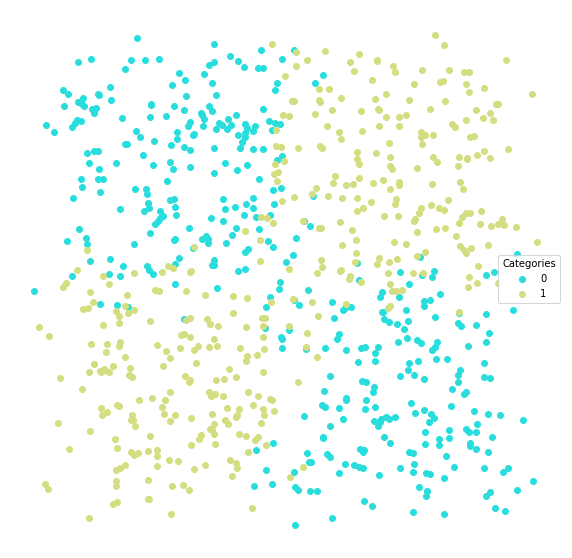

In [3]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [4]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [5]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [6]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.155,0.844634,0.869565,0.797679,0.808081
1,0.155,0.844634,0.824074,0.786164,0.881188


This lets us look at which classes do better:

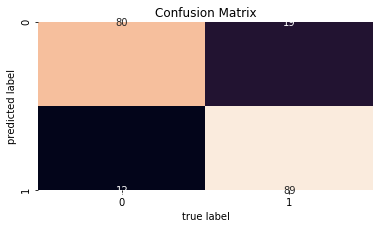

In [7]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

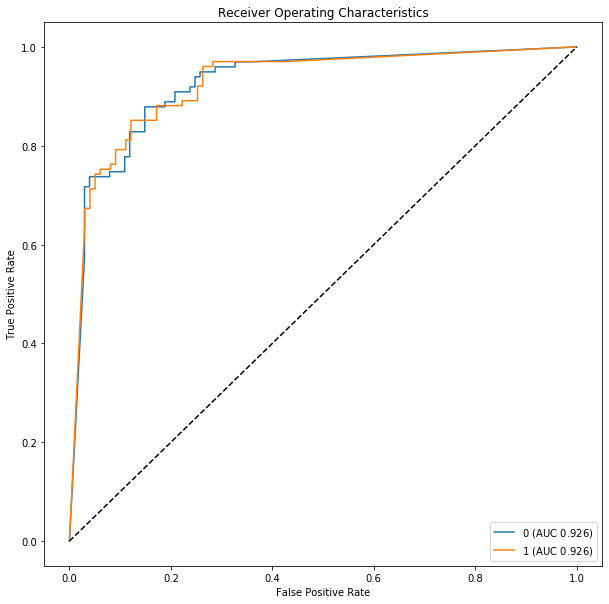

In [8]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


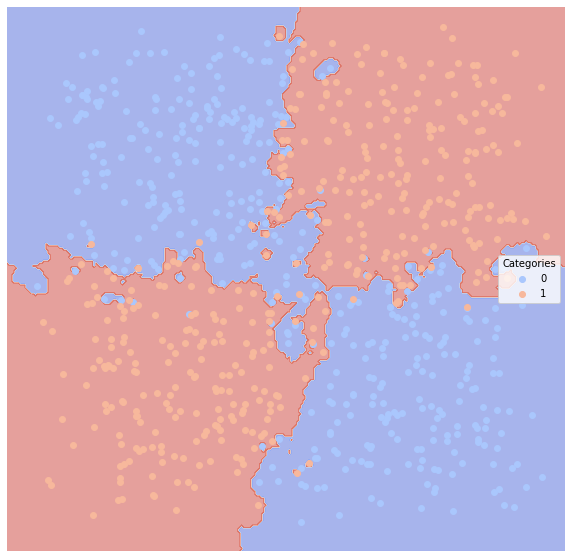

In [9]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [10]:
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [11]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [12]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [13]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.52,0.478948,0.468354,0.485042,0.373737
1,0.52,0.478948,0.487603,0.494838,0.584158


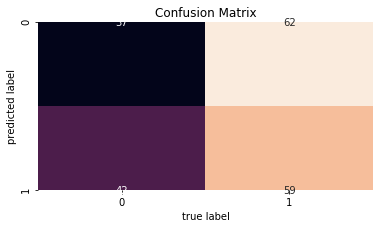

In [14]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

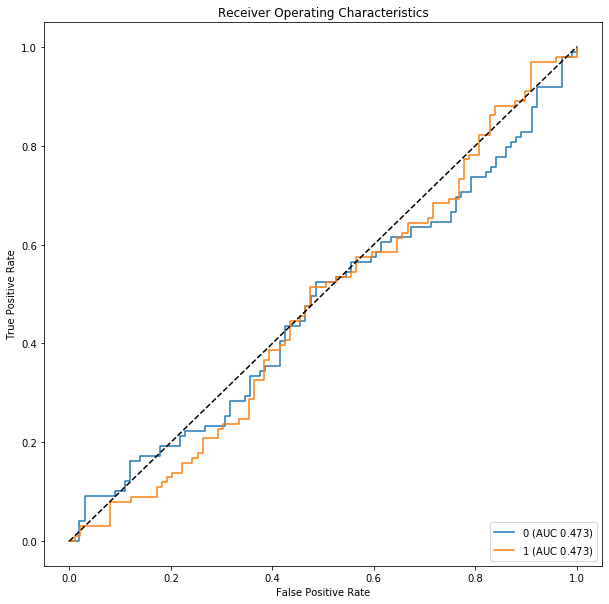

In [15]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


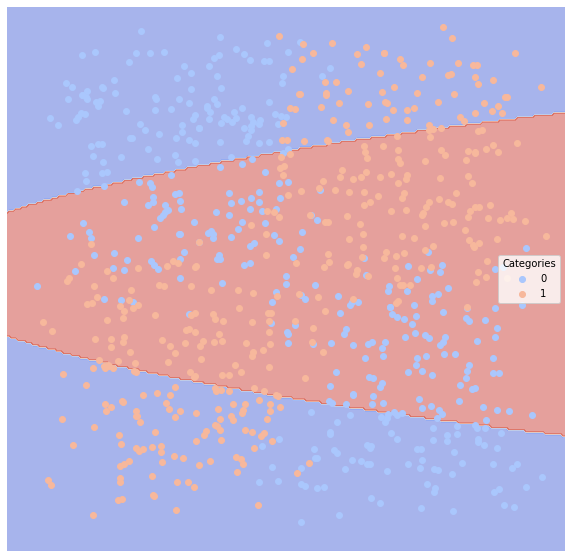

In [16]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [331]:
#Here I'm creating 10 disticnt datasets
low_noise = 0.1
high_noise= 0.5
dfTrain0, dfTest0 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random()) #which parameters does the random take?
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(low_noise))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(high_noise))
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(low_noise)) #Please try this one
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(high_noise)) #Please try this one
dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(low_noise))
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(high_noise))
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(low_noise))
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(high_noise))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


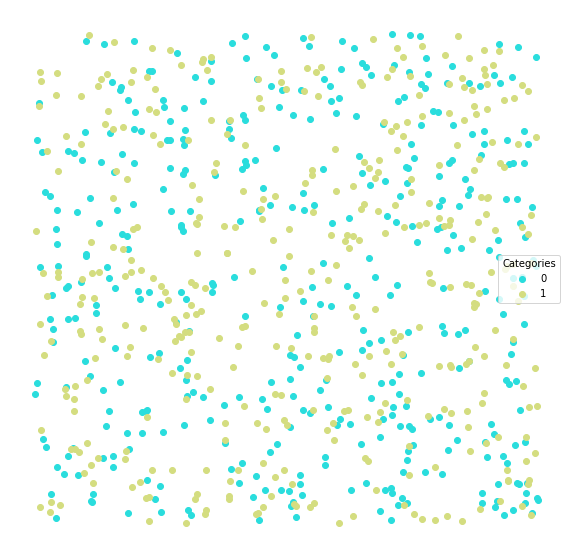

In [447]:
dfTrain0, dfTest0 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
lucem_illud_2020.plotter(dfTrain)

In [596]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [597]:
clf.fit(np.stack(dfTrain0['vect'], axis=0), dfTrain0['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [598]:
lucem_illud_2020.evaluateClassifier(clf, dfTest0)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.51,0.493116,0.527473,0.531623,0.448598
1,0.51,0.493116,0.458716,0.461621,0.537634


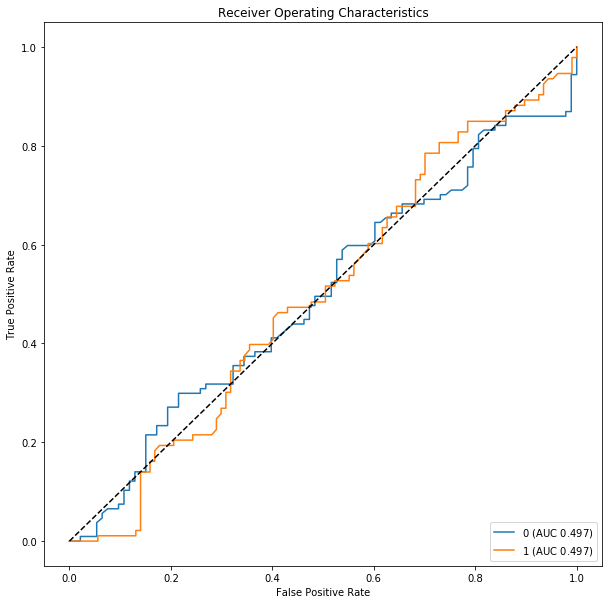

In [599]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest0)
lucem_illud_2020.plotMultiROC(clf, dfTest0)
#lucem_illud_2020.plotregions(clf, dfTrain0)

In [ ]:
#For random distributed data, Naive Bayes classifier predicts categories similar to assigning classes by chance. 
#There is almost no space under the curve. 
#In general Naive Bayes assumes that the effect of a particular feature in a class is independent of other features. 
#This assumption simplifies computation. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


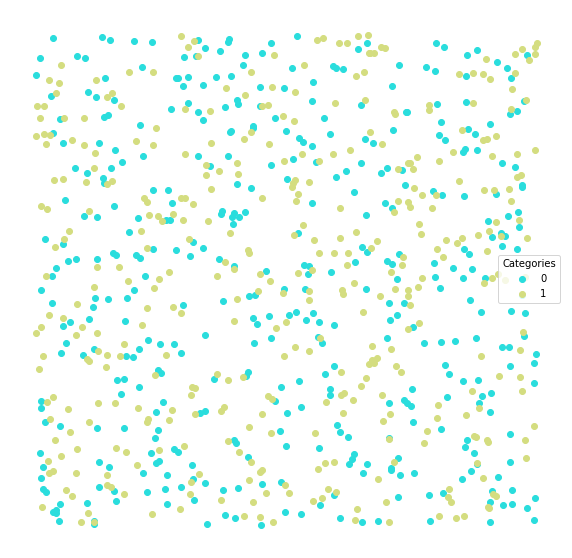

In [478]:
dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random()) 
lucem_illud_2020.plotter(dfTrain1)

In [479]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists

#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()


In [480]:
clf.fit(np.stack(dfTrain1['vect'], axis=0), dfTrain1['category'])

GaussianNB(priors=None, var_smoothing=1e-09)

In [481]:
lucem_illud_2020.evaluateClassifier(clf, dfTest1)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.545,0.490019,0.449438,0.450111,0.879121
1,0.545,0.490019,0.500000,0.540459,0.100917


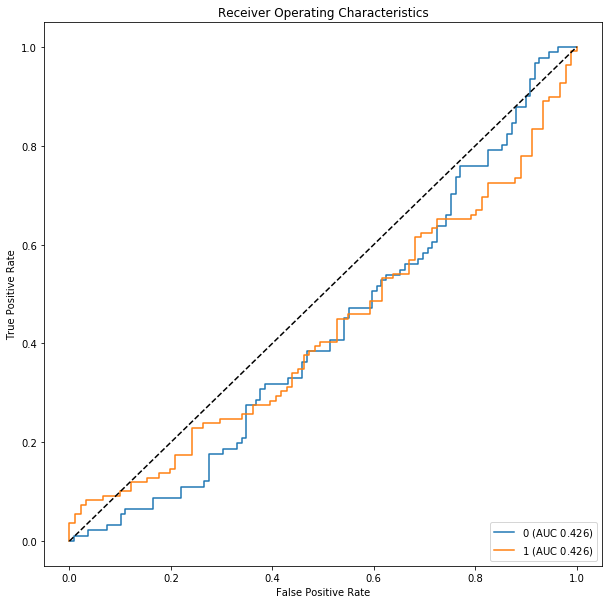

In [482]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest1)
lucem_illud_2020.plotMultiROC(clf, dfTest1)
#lucem_illud_2020.plotregions(clf, dfTrain1)

In [ ]:
#For random distributed data, Naive Bayes classifier predicts categories similar to assigning classes by chance. 
#There is almost no space under the curve. 
#In general Naive Bayes assumes that the effect of a particular feature in a class is independent of other features. 
#This assumption simplifies computation. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


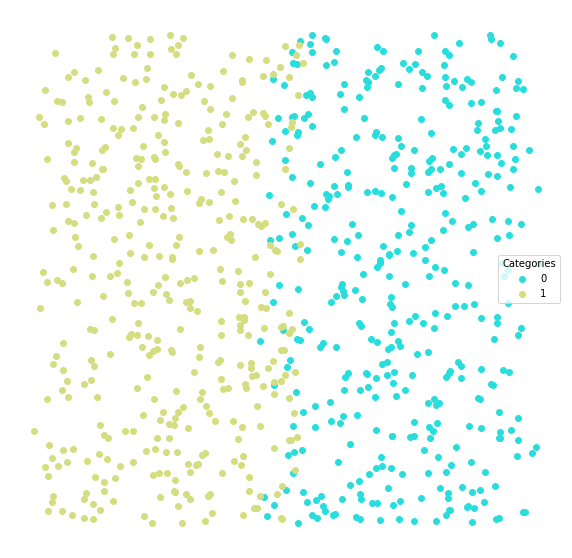

In [483]:
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(low_noise))
lucem_illud_2020.plotter(dfTrain2)

In [652]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()


In [653]:
clf.fit(np.stack(dfTrain2['vect'], axis=0), dfTrain['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [654]:
lucem_illud_2020.evaluateClassifier(clf, dfTest2)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.325,0.675862,0.71,0.651121,0.663551
1,0.325,0.675862,0.64,0.585430,0.688172


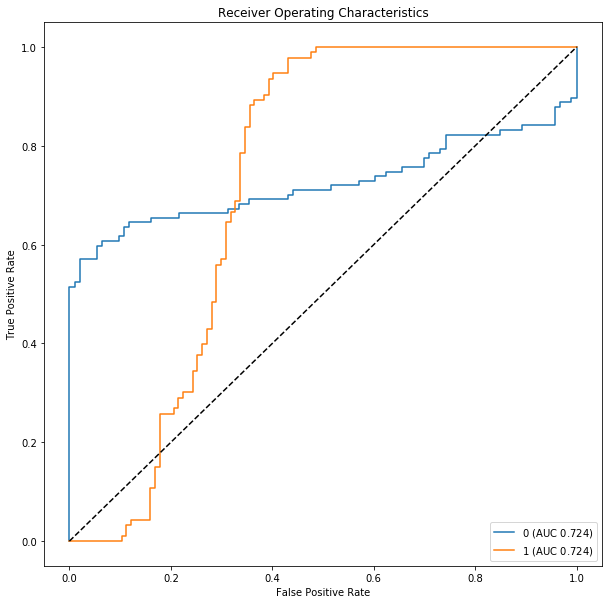

In [655]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest2)
lucem_illud_2020.plotMultiROC(clf, dfTest2)
#lucem_illud_2020.plotregions(clf, dfTrain2)

In [ ]:
#I have chosen the neural network classifier because I have seen it used in several publications and wanted to try it myself.
#Neural networks are models, which try to mimic the way the human brain develops classification rules. 
#A neural net consists of many different layers, with each layer receiving inputs from previous layers, and passing outputs to further layers. 
#The output depends on the weight given to a specific link bettwen the layers, the fuction which connects them.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


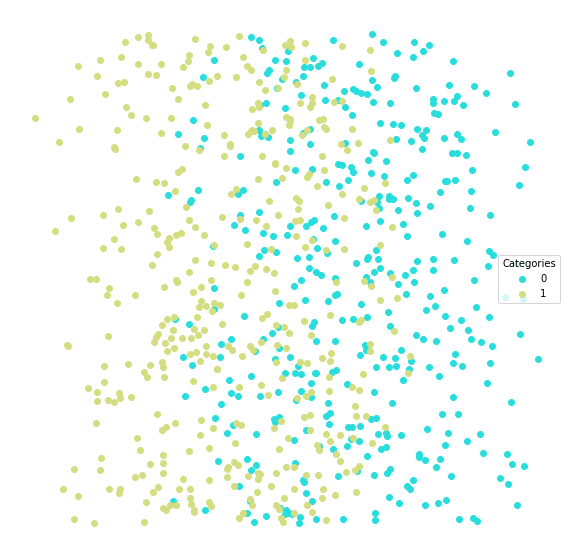

In [689]:
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(high_noise))
lucem_illud_2020.plotter(dfTrain3)

In [690]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [691]:
clf.fit(np.stack(dfTrain3['vect'], axis=0), dfTrain3['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [692]:
lucem_illud_2020.evaluateClassifier(clf, dfTest3)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.285,0.719478,0.776596,0.700105,0.669725
1,0.285,0.719478,0.660377,0.612983,0.769231


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


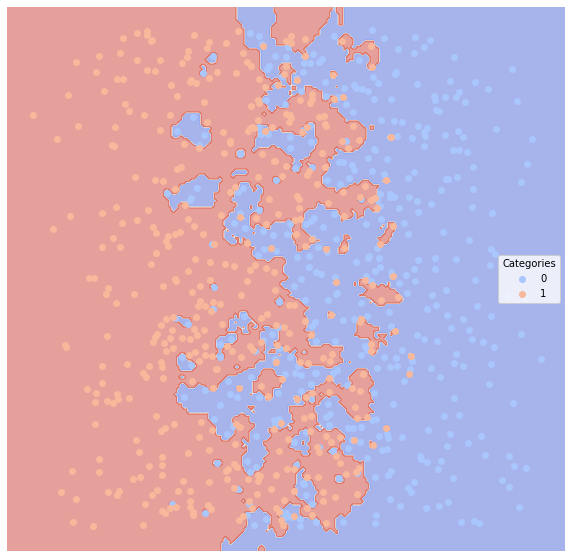

In [693]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest3)
#lucem_illud_2020.plotMultiROC(clf, dfTest3)
lucem_illud_2020.plotregions(clf, dfTrain3)

In [694]:
#The nice thing that we can see here is that taken 5 neighbors into account, the classifier predicts the points in the middle sometimes as red, sometimes as blue categories. 
#If we would increase the number of points taken into account to, e.g., 200, we would receive a more straightforward vertical line. 

#The nearest neighbor classifier gives a good estimation about the different categories of the points.
#To predict the category of a point, the classifier calculates the distance to a given set of points in the environment. 
#The classifier usually gives more precise results the smaller the number of points it has to take into account.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


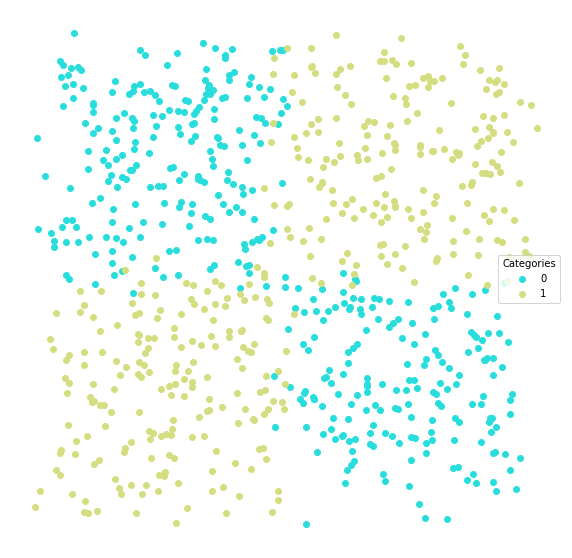

In [695]:
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(low_noise)) 
lucem_illud_2020.plotter(dfTrain4)

In [696]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()


In [697]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [698]:
lucem_illud_2020.evaluateClassifier(clf, dfTest4)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.33,0.674227,0.625000,0.585426,0.744681
1,0.33,0.674227,0.727273,0.649108,0.603774


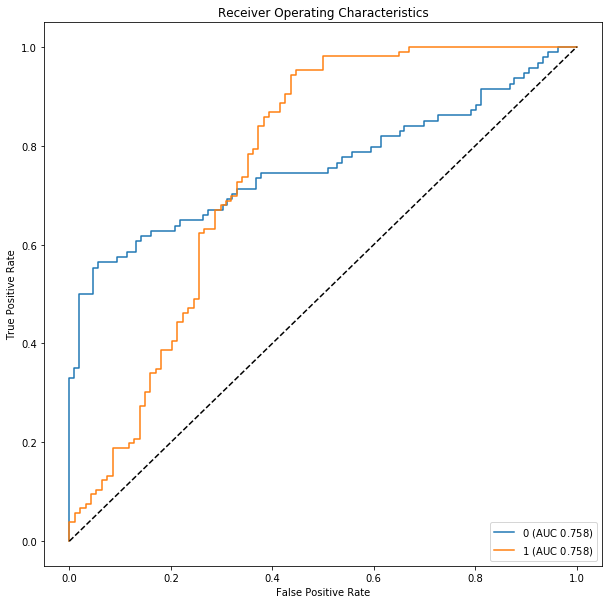

In [699]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest4)
lucem_illud_2020.plotMultiROC(clf, dfTest4)
#lucem_illud_2020.plotregions(clf, dfTrain4)

In [700]:
#The precision rate is 0.62 and 0.72 - quite mediocre. The Area und the curve resembels that result (and has values of 0.67 and 0.67).
#THe identical valuyes for the AUC for 0 and 1 indicate that the cuves are symmetrical

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


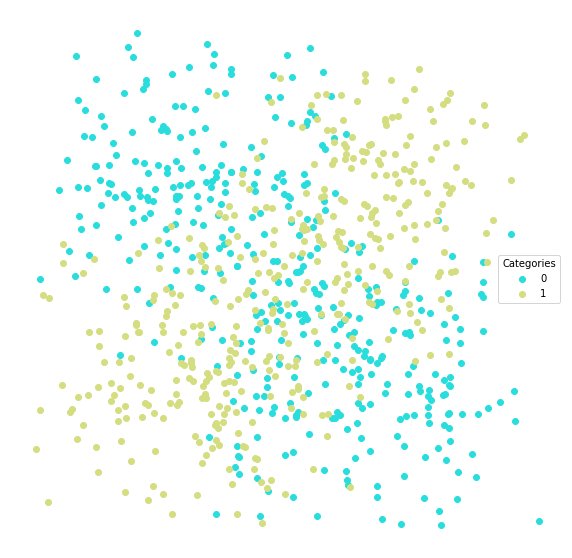

In [701]:
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(high_noise)) 
lucem_illud_2020.plotter(dfTrain5)

In [702]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [703]:
clf.fit(np.stack(dfTrain5['vect'], axis=0), dfTrain5['category'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [704]:
lucem_illud_2020.evaluateClassifier(clf, dfTest5)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.23,0.769708,0.770833,0.702058,0.755102
1,0.23,0.769708,0.769231,0.713318,0.784314


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


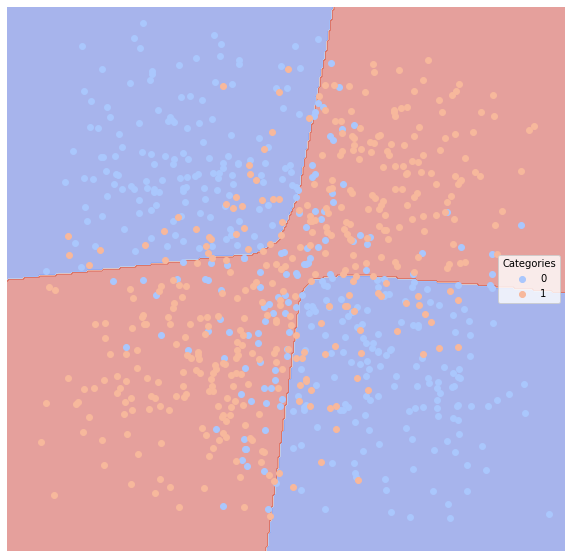

In [705]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest5)
#lucem_illud_2020.plotMultiROC(clf, dfTest5)
lucem_illud_2020.plotregions(clf, dfTrain5)

In [706]:
#The neural networks classifier works pretty good for this dataset and xorSplit. 
#It shows a high precision rate of 0.91 and 0.81
#The regions identified as one class (red vs. blue) are resembling the xorSplit

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


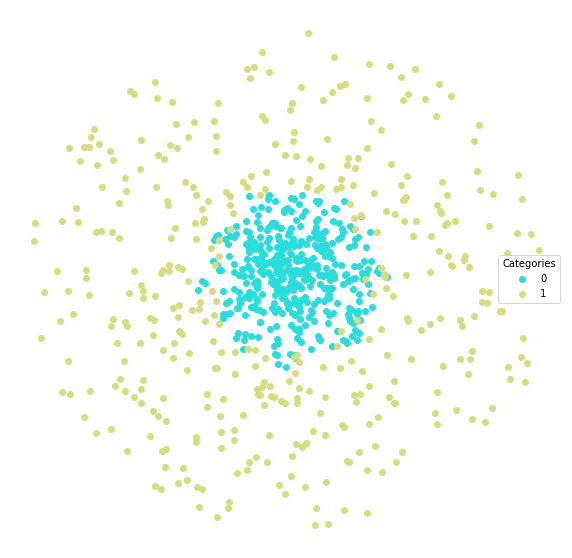

In [707]:
dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(low_noise))
lucem_illud_2020.plotter(dfTrain6)

In [708]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()


In [709]:
clf.fit(np.stack(dfTrain6['vect'], axis=0), dfTrain6['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [710]:
lucem_illud_2020.evaluateClassifier(clf, dfTest6)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.055,0.944949,0.934066,0.907173,0.944444
1,0.055,0.944949,0.954128,0.932085,0.945455


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


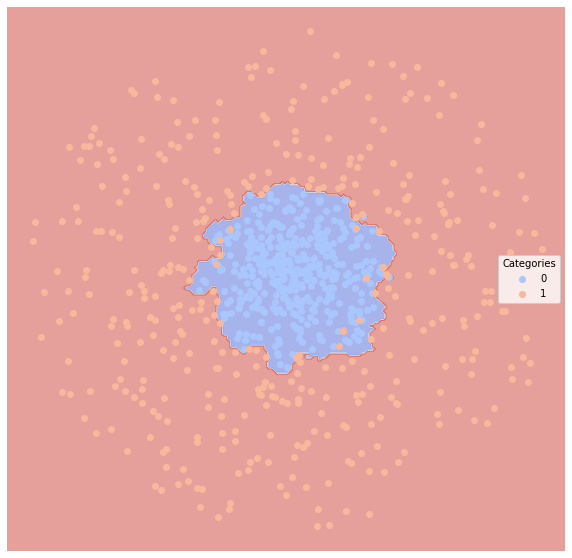

In [711]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest6)
#lucem_illud_2020.plotMultiROC(clf, dfTest6)
lucem_illud_2020.plotregions(clf, dfTrain6)

In [712]:
#The neares neighbor classifier gives a pretty precise estimation about the different categories of the points.
#To predict the category of a point, the classifier calculates the distance to a given set of points in the einvironment. 
#The classifiere usually gives more precise results the smaller the number of points it has to take into account. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


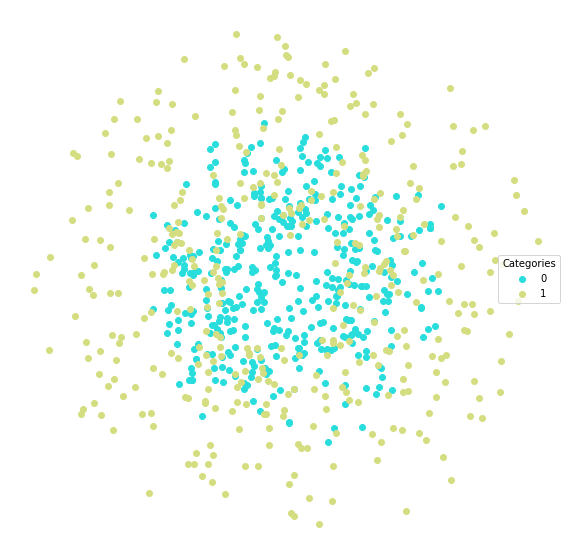

In [713]:
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(high_noise))
lucem_illud_2020.plotter(dfTrain7)

In [714]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(200, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [715]:
clf.fit(np.stack(dfTrain7['vect'], axis=0), dfTrain7['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='distance')

In [716]:
lucem_illud_2020.evaluateClassifier(clf, dfTest7)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.285,0.73128,0.627737,0.616798,0.934783
1,0.285,0.73128,0.904762,0.732513,0.527778


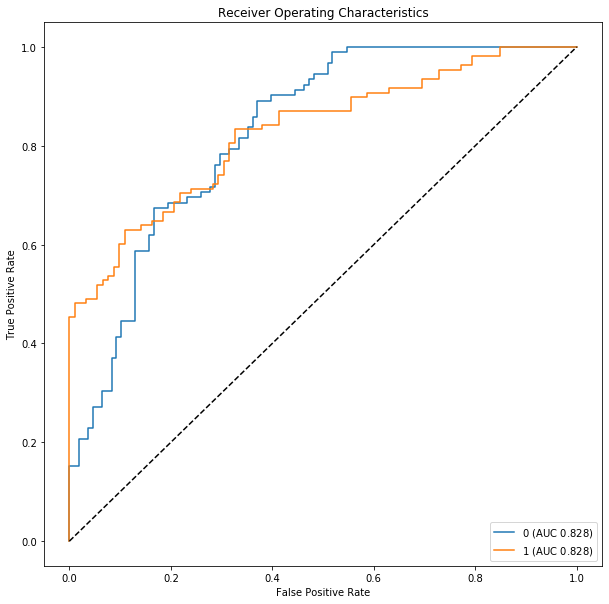

In [717]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest7)
lucem_illud_2020.plotMultiROC(clf, dfTest7)
#lucem_illud_2020.plotregions(clf, dfTrain7)

In [718]:
#The noise in dataset7 is pretty high. 
#If I would take only 5 nieghbors into account, the neares neighbor classifier would have difficulties to predict the correct categories for the points. 
#Raising the number of points taken into account to 200, the classifier works better. 
#The AUC curve resembles the improvement - it would otherwise have lower values.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

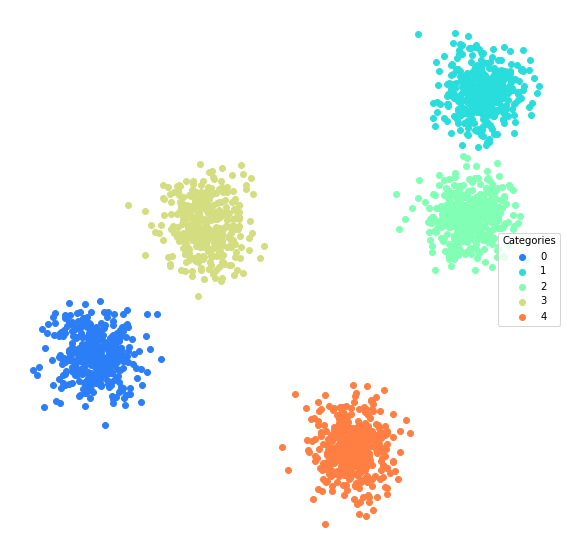

In [720]:
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(low_noise))
lucem_illud_2020.plotter(dfTrain8)

In [721]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()



In [722]:
clf.fit(np.stack(dfTrain8['vect'], axis=0), dfTrain8['category'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [723]:
lucem_illud_2020.evaluateClassifier(clf, dfTest8)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.004,0.993605,0.989691,0.981488,0.989691
2,0.004,0.994055,0.990654,0.983396,0.990654
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.000,1.000000,1.000000,1.000000,1.000000


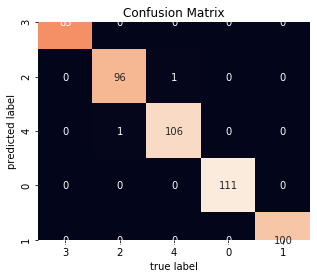

In [724]:
#Now, I’m visualizing the result
lucem_illud_2020.plotConfusionMatrix(clf, dfTest8)
#lucem_illud_2020.plotMultiROC(clf, dfTest8)
#lucem_illud_2020.plotregions(clf, dfTrain8)

In [ ]:
#RandomForestClassifier performs pretty good.
#RandomForestClassifier operates by constructing a multitude of decision trees.
#The confusion matrix shows the correct and wrong predictions for each value. The correct results are very high, the wrong predicitons very low.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

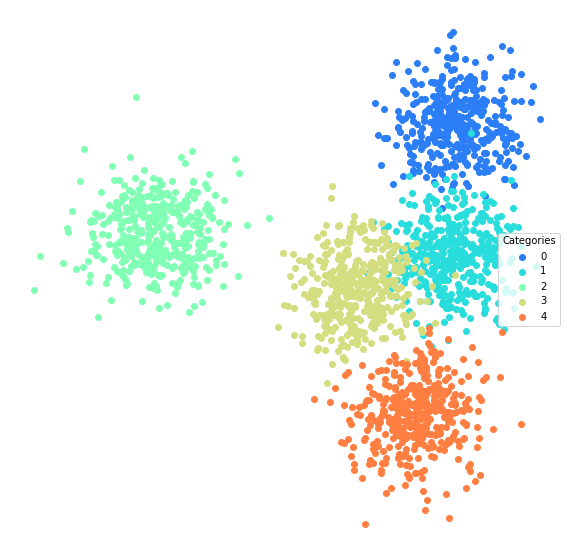

In [589]:
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(high_noise))
lucem_illud_2020.plotter(dfTrain9)

In [590]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [591]:
clf.fit(np.stack(dfTrain9['vect'], axis=0), dfTrain9['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [445]:
lucem_illud_2020.evaluateClassifier(clf, dfTest9)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.000,1.000000,1.000000,1.000000,1.000000
1,0.010,0.984621,0.965116,0.946408,0.976471
2,0.000,1.000000,1.000000,1.000000,1.000000
3,0.052,0.918569,0.909910,0.817478,0.863248
4,0.042,0.941845,0.870000,0.812737,0.915789


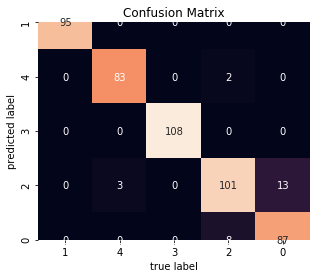

In [446]:
#Now, I’m visualizing the result
lucem_illud_2020.plotConfusionMatrix(clf, dfTest9)
#lucem_illud_2020.plotMultiROC(clf, dfTest9)
#lucem_illud_2020.plotregions(clf, dfTrain9)

In [736]:
#The gradient boosting classifier combines many weak(er) learning models together. 
#In that iterative way, they create a strong predictive model.
#The confusion matrix shows that most of the predictions were correct.

In [ ]:
#I'm doing this now for real data, starting with reddit

In [837]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())

Loading Reddit data
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

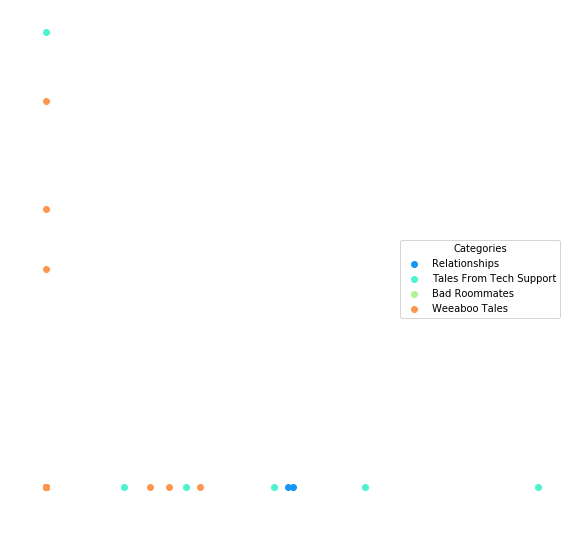

In [839]:
lucem_illud_2020.plotter(dfTrain)

In [840]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [841]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [842]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.103448,0.857132,0.851852,0.718917,0.766667
Tales From Tech Support,0.021944,0.956309,0.985075,0.921794,0.916667
Bad Roommates,0.068966,0.916553,0.845238,0.778362,0.887500
Weeaboo Tales,0.081505,0.910862,0.793103,0.735781,0.896104


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

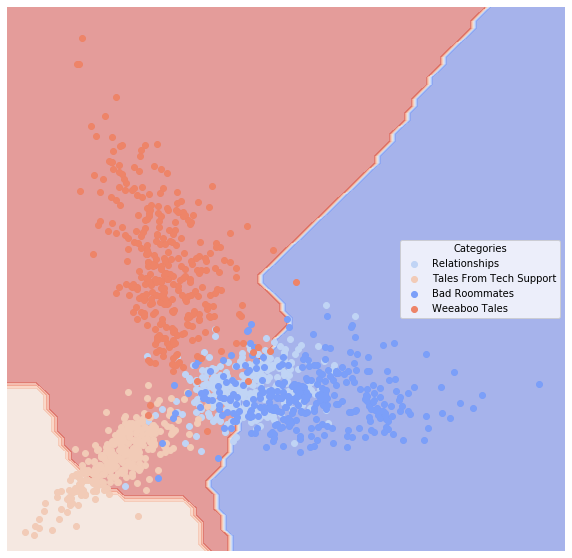

In [843]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#The nearest neighbor classifier shows that the categories are relativeley distinct. 

In [ ]:
#I'm doing this now for NewsGroup

In [844]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

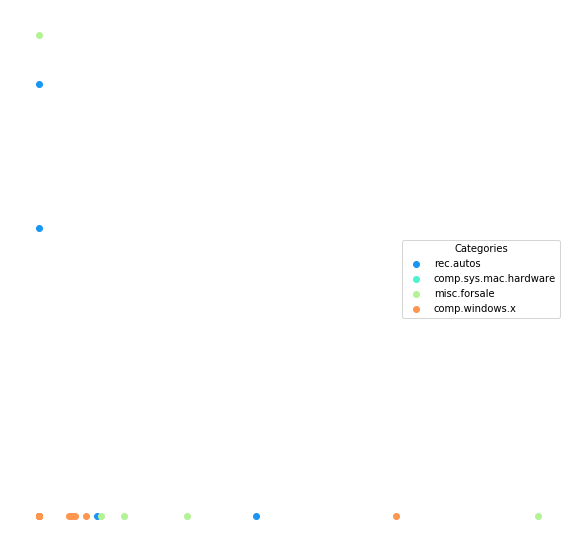

In [845]:
lucem_illud_2020.plotter(dfTrain)

In [846]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [847]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [848]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.074468,0.925951,0.814286,0.773853,0.926829
comp.sys.mac.hardware,0.072340,0.888452,0.898148,0.774939,0.808333
misc.forsale,0.057447,0.910141,0.904762,0.803602,0.848214
comp.windows.x,0.029787,0.962645,0.931624,0.895783,0.947826


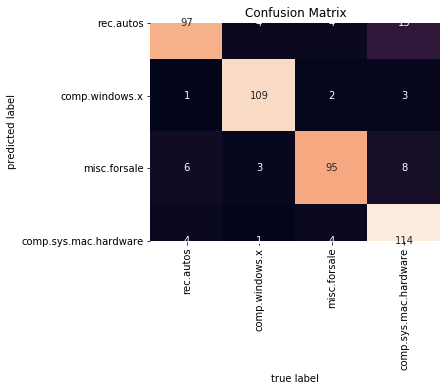

In [851]:
#Now, I’m visualizing the result
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
#lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#THe predictions are fairly good. I can see this. e.g., from the first column of the confusion matrix: of the 108 true rec.autos entries, 97 were categorized corretly. 

In [ ]:
#I'm doing this now for SenateSmall

In [852]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())

Loading senate data
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


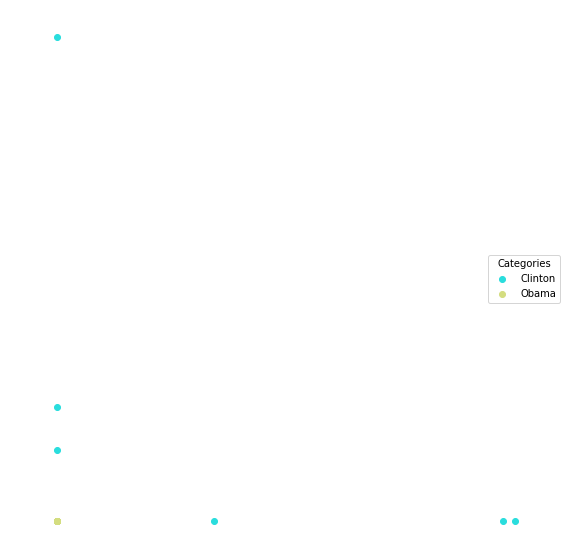

In [853]:
lucem_illud_2020.plotter(dfTrain)

In [854]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [855]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [856]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.123167,0.87288,0.878173,0.848199,0.905759
Obama,0.123167,0.87288,0.875000,0.805381,0.840000


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


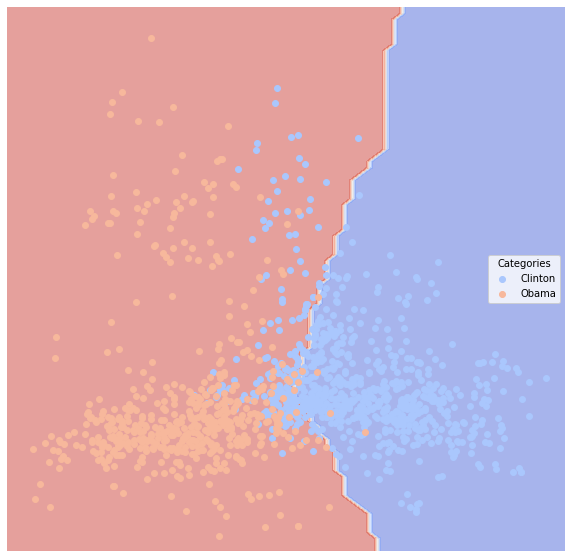

In [857]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [858]:
#I'm doing this now for SenateLarge

In [859]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())

Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

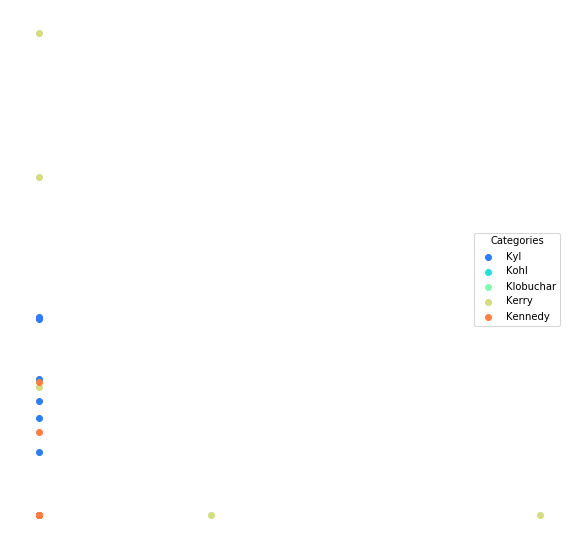

In [860]:
lucem_illud_2020.plotter(dfTrain)

In [861]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [862]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [863]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Kyl,0.046154,0.844656,0.948052,0.700147,0.695238
Klobuchar,0.025641,0.898076,0.885246,0.730148,0.805970
Kohl,0.033333,0.853300,0.872727,0.649596,0.716418
Kerry,0.151282,0.760690,0.773333,0.556226,0.580000
Kennedy,0.184615,0.828135,0.725400,0.705115,0.929619


In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#I'm doing this now for Spam

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [ ]:
lucem_illud_2020.plotter(dfTrain)

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble 
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [725]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [726]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [727]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [728]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [729]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [730]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [731]:
TFVects.shape

(1368, 11235)

We can save this in the dataframe to make things easier

In [732]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [733]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [734]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


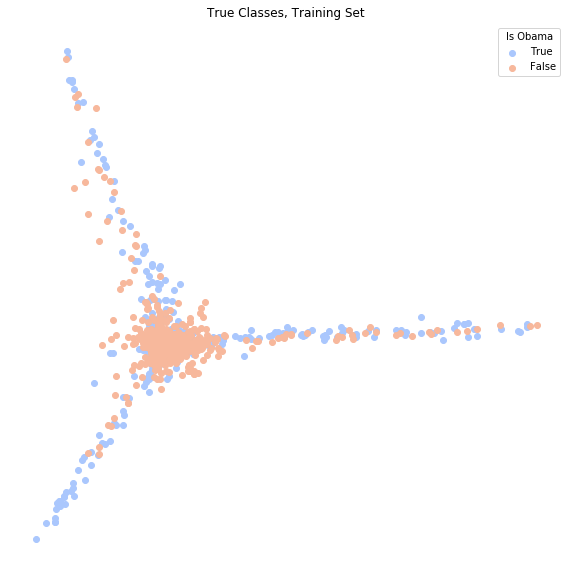

In [735]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

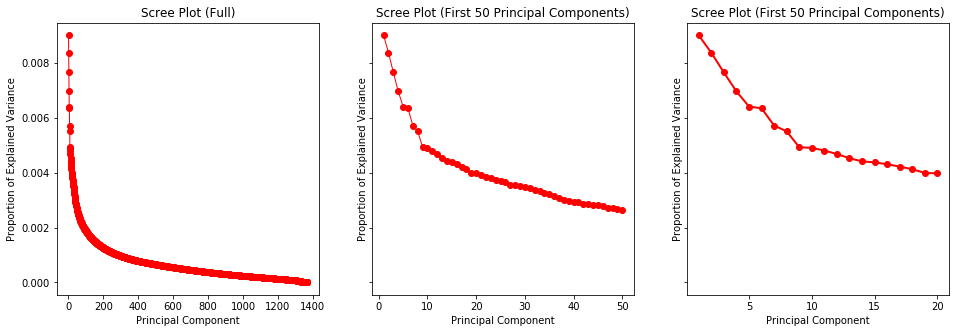

In [60]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [61]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [62]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [63]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6703216374269005

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [64]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6217008797653959

Slightly poorer. How about using more dimensions (40)?

In [65]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7441520467836257
Testing:
0.6744868035190615


Or still more (100)?

In [66]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8362573099415205
Testing:
0.750733137829912


Or even more (200)!

In [67]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8706140350877193
Testing:
0.7741935483870968


This is becoming ridiculous (400)!

In [68]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9057017543859649
Testing:
0.8064516129032258


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [69]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9554093567251462


Train the model using training data, and then test it on the testing data.

In [70]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8123167155425219


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [71]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [72]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9612573099415205
Testing:
0.873900293255132


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [73]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [74]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8133333333333334

Recall:

In [75]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8905109489051095

F1-measure:

In [76]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.8501742160278746

Let's take a look at how well our posterior distribution looks relative to the truth.

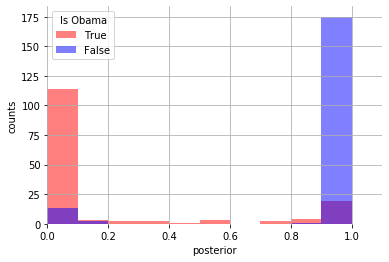

In [77]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [78]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,signature,-2.255617,labolt,-1.714600
1,island,-2.279427,5566,-1.755010
2,announcement,-2.303819,amy,-1.818861
3,awarded,-2.328820,dick,-1.863813
4,urging,-2.328820,brundage,-1.910880
5,fy,-2.341559,chicago,-1.985915
6,welcomed,-2.341559,temporary,-2.110213
7,read,-2.380780,location,-2.202587
8,ground,-2.407809,political,-2.218847
9,growing,-2.421602,writing,-2.218847


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [79]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [80]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [81]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [82]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [83]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [84]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [85]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [86]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.9024956471271038


In [87]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1275,sci.space,sci.space
1135,sci.space,sci.space
534,soc.religion.christian,soc.religion.christian
1646,comp.graphics,comp.graphics
838,soc.religion.christian,soc.religion.christian
482,soc.religion.christian,soc.religion.christian
1016,sci.space,sci.space
109,talk.religion.misc,talk.religion.misc
811,soc.religion.christian,soc.religion.christian
1873,comp.graphics,comp.graphics


Looks pretty good, lets examine the testing dataset:

In [88]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7953488372093023


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(logistic, test_data_df)
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

Let's calculate the precision, recall, and F-measures.

In [90]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.9079444345265287
0.7953488372093023
0.8300673534416755


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [91]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
sci.space,0.060465,0.922253,0.871560,0.801722,0.887850
soc.religion.christian,0.165116,0.869117,0.650538,0.633757,0.952756
comp.graphics,0.037209,0.956119,0.925620,0.887451,0.941176
talk.religion.misc,0.146512,0.590909,1.000000,0.328330,0.181818


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

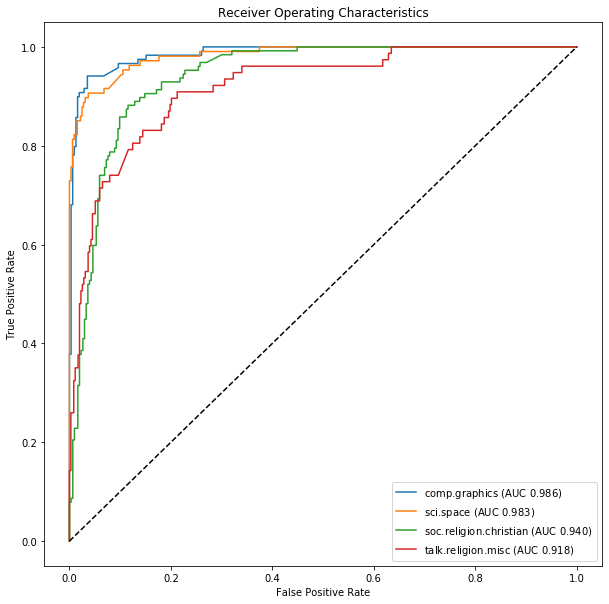

In [92]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

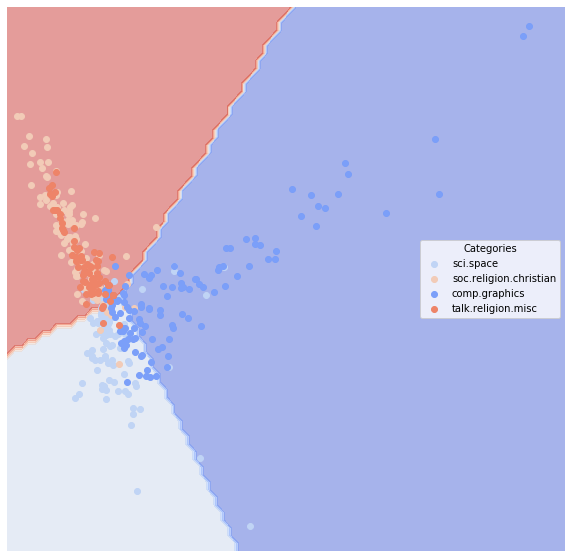

In [93]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

In [744]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())

Loading Reddit data
Converting to vectors


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

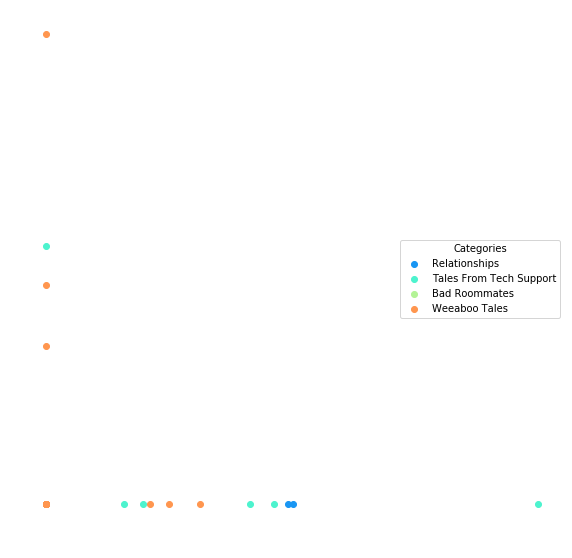

In [745]:
lucem_illud_2020.plotter(dfTrain)

In [746]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble - 9
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [834]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [835]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.084639,0.860011,0.861538,0.708401,0.756757
Tales From Tech Support,0.040752,0.935000,1.000000,0.910752,0.870000
Bad Roommates,0.053292,0.923248,0.869565,0.792342,0.882353
Weeaboo Tales,0.078370,0.939492,0.765306,0.751698,0.974026


In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#Now, I'm doing this for the loadNewsGroup

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())

In [ ]:
lucem_illud_2020.plotter(dfTrain)

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble - 9
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
#Now, I'm doing this for the SenateSmall

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())

In [ ]:
lucem_illud_2020.plotter(dfTrain)

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble - 9
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#Now, I'm doing this for the SenateLarge

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())

In [ ]:
lucem_illud_2020.plotter(dfTrain)

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble - 9
#clf = sklearn.ensemble.GradientBoostingClassifier()


In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

In [ ]:
#Now, I'm doing this for loadSpam

In [ ]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

In [ ]:
lucem_illud_2020.plotter(dfTrain3)

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble - 9
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

In [ ]:
#Now, I’m visualizing the result
#lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
#lucem_illud_2020.plotMultiROC(clf, dfTest)
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [143]:
#I'm importing the reddit dataset
reddit = pandas.read_csv('../data/reddit.csv', index_col=0)
#604 rows, 49 colums
reddit.shape

(1600, 7)

In [144]:
#give preview
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 1599
Data columns (total 7 columns):
author       1600 non-null object
over_18      1600 non-null bool
score        1600 non-null int64
subreddit    1600 non-null object
text         1598 non-null object
title        1600 non-null object
url          1600 non-null object
dtypes: bool(1), int64(1), object(5)
memory usage: 89.1+ KB


In [145]:
#df.iloc[0,:]
reddit.iloc[0, :]

author                                        guitarsdontdance
over_18                                                  False
score                                                    14089
subreddit                              Tales From Tech Support
text         So my story starts on what was a normal day ta...
title        "Don't bother sending a tech, I'll be dead by ...
url          https://www.reddit.com/r/talesfromtechsupport/...
Name: 0, dtype: object

In [146]:
#I'm checking for null values, returns boolean array
#obviously the dataset has many null values
reddit.isnull()

,author,over_18,score,subreddit,text,title,url
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1595,False,False,False,False,False,False,False
1596,False,False,False,False,False,False,False
1597,False,False,False,False,False,False,False
1598,False,False,False,False,False,False,False


In [147]:
#I print the index, datatype and memory information
reddit.head()

,author,over_18,score,subreddit,text,title,url
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...


In [149]:
#I print the text in the dataset for the "text" column
reddit['text']

0       So my story starts on what was a normal day ta...
1       > $Me  - Hello, IT.   > $Usr - Hi, I am still ...
2       [Part 1](http://www.reddit.com/r/talesfromtech...
3       Another tale from the out of hours IT desk... ...
4       This just happened...  So, I had a laptop syst...
                              ...                        
1595    I don't know if this is the right place for th...
1596    [My OP](http://redd.it/3dijz7)  Thanks for you...
1597    I don't know how to react. Everything is such ...
1598    [Original post here.](https://www.reddit.com/r...
1599    Original post -- https://www.reddit.com/r/rela...
Name: text, Length: 1600, dtype: object

In [151]:
#I' chekcing if the reddit data recognizes every row as a string
#yes, it does so!
reddit['text'].map(type) == str

0       True
1       True
2       True
3       True
4       True
        ... 
1595    True
1596    True
1597    True
1598    True
1599    True
Name: text, Length: 1600, dtype: bool

In [155]:
 lucem_illud_2020.word_tokenize(reddit['text'][1])

['>',
 '$',
 'Me',
 'Hello',
 'IT',
 '>',
 '$',
 'Usr',
 'Hi',
 'I',
 'am',
 'still',
 'off',
 'sick',
 'but',
 'I',
 'am',
 'not',
 '>',
 '$',
 'Me',
 'Oh',
 'did',
 'you',
 'mean',
 'to',
 'call',
 'HR',
 'or',
 'is',
 'there',
 'an',
 'IT',
 'issue',
 '>',
 '$',
 'Usr',
 'It',
 "'s",
 'an',
 'IT',
 'issue',
 'I',
 'am',
 'back',
 'at',
 'work',
 'now',
 'but',
 'I',
 'am',
 'still',
 'sick',
 '>',
 '$',
 'Me',
 'I',
 'do',
 "n't",
 'understand',
 'the',
 'issue',
 '>',
 '$',
 'Usr',
 'I',
 'have',
 'tried',
 'to',
 'log',
 'into',
 '$',
 'HRsystem',
 'but',
 'it',
 'has',
 'me',
 'listed',
 'as',
 'off',
 'sick',
 '>',
 '$',
 'Me',
 'Ah',
 'I',
 'see',
 'You',
 'need',
 'to',
 'add',
 'an',
 'end',
 'date',
 'to',
 'your',
 'sickness',
 '>',
 '$',
 'Usr',
 'But',
 'I',
 'am',
 'back',
 'now',
 '>',
 '$',
 'Me',
 'That',
 "'s",
 'ok',
 'you',
 'need',
 'to',
 'fill',
 'in',
 'the',
 'date',
 'field',
 'with',
 'when',
 'you',
 'came',
 'back',
 '>',
 '$',
 'Usr',
 'I',
 'am',
 'back'

In [148]:
#I'm tokenizing and normalizing the dataset
reddit['tokenized_text'] = reddit['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
reddit['normalized_text'] = reddit['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

TypeError: object of type 'float' has no len()

In [ ]:
#This error left me and my study group puzzled with not enough time left to fighure it out
#For that reason, I continue with the ObamaClinton dataset and set s== Clinton in ObamaClinttonReleases

In [ ]:
#Because the exmaple that was provided tried to predict for Obama, I'm no switching to prediction for Clinton. 

In [737]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

In [738]:
ObamaClintonReleases['category'] = [s == 'Clinton' for s in ObamaClintonReleases['targetSenator']]

In [739]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [740]:
#I'm splitting the data in training data and test data
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [741]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


In [747]:
#I'm now performing logistic regression

In [748]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [749]:
TFVects.shape

(1368, 11517)

In [750]:
#I'm saving this data
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [751]:
#I'm reducing the dimensions
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [752]:
#I'm storing the PCA space vectors in the dataframe
train_data_df['pca'] = [r for r in reduced_data]

In [ ]:
#I'm visualizing the data
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

In [ ]:
#The PCA can distinguish Clinton only with mediocre quality. 
#I'm going on with a screeplot to see how many Principal Components I need

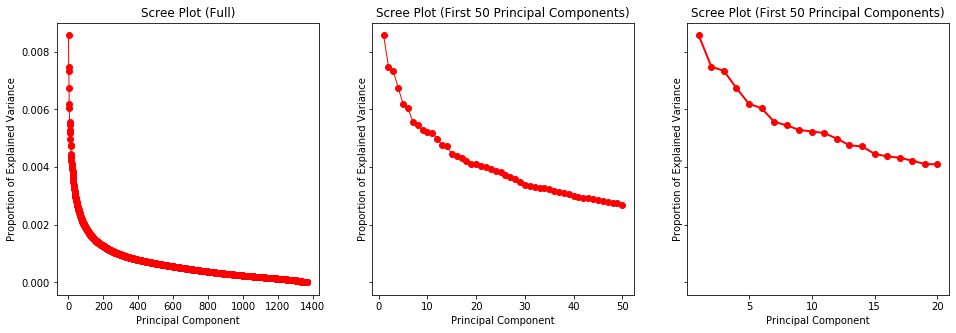

In [754]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [755]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [756]:
#Now, I'm fitting a logisitc regression to the data
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [757]:
#I'm calculating the mean accuracy of the logistic regression on the training dataset. 
#It has a value of 0.68 - that means, it is performing mediocre. 
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6827485380116959

In [758]:
#I'm now checking how the locistic regression performs on the testing dataset.
#The result is 0.65 - that is somwhat poorer than the for the training dataset.
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6510263929618768

In [759]:
#I'm now increasing the dimensions to 40
#The results for the logistic regressions on the training dataset and the testing dataset improve.
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7324561403508771
Testing:
0.7038123167155426


In [760]:
#I'm now increasing the dimensions to 40
#The results for the logistic regressions on the training dataset and the testing dataset improve further.
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8296783625730995
Testing:
0.7771260997067448


In [761]:
#I'm now increasing the dimensions to 200
#The results for the logistic regressions on the training dataset and the testing dataset improve further.
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8676900584795322
Testing:
0.8152492668621701


In [762]:
#I'm now increasing the dimensions to 400
#The results for the logistic regressions on the training dataset and the testing dataset improve further.
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9064327485380117
Testing:
0.841642228739003


In [763]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9554093567251462


In [764]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.844574780058651


In [812]:
#I'm printing a confusion matrix
lucem_illud_2020.plotConfusionMatrix(logistic_l1, test_data_df)

ValueError: X has 11509 features per sample; expecting 11517

In [813]:
#Precision
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.7567567567567568

In [814]:
#Recall
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.865979381443299

In [815]:
#F-1 measure
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8076923076923077

In [817]:
lucem_illud_2020.plotMultiROC(logistic_l1, test_data_df)

ValueError: X has 11509 features per sample; expecting 11517

In [765]:
#Now, I'm doing this with naive bayes

In [766]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [767]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9612573099415205
Testing:
0.9120234604105572


In [768]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [769]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.9128205128205128

In [770]:
#Recall
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.9319371727748691

In [771]:
#F-1 measure
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.9222797927461139

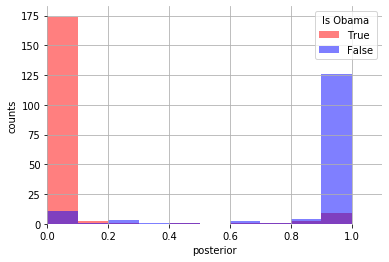

In [772]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [773]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,amy,-1.829911,signature,-2.165669
1,monday,-1.875374,announcement,-2.279427
2,dick,-1.898904,awarded,-2.291549
3,brundage,-1.910880,welcomed,-2.303819
4,chicago,-1.947694,fy,-2.316241
5,temporary,-2.186586,island,-2.341559
6,location,-2.202587,urging,-2.341559
7,reform,-2.218847,growing,-2.394203
8,cases,-2.286670,point,-2.407809
9,writing,-2.322388,urban,-2.407809


In [824]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_data_df)

ValueError: Expected input with 11517 features, got 11509 instead

In [820]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.7567567567567568

In [821]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.865979381443299

In [822]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8076923076923077

In [825]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_data_df)

ValueError: Expected input with 11517 features, got 11509 instead

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

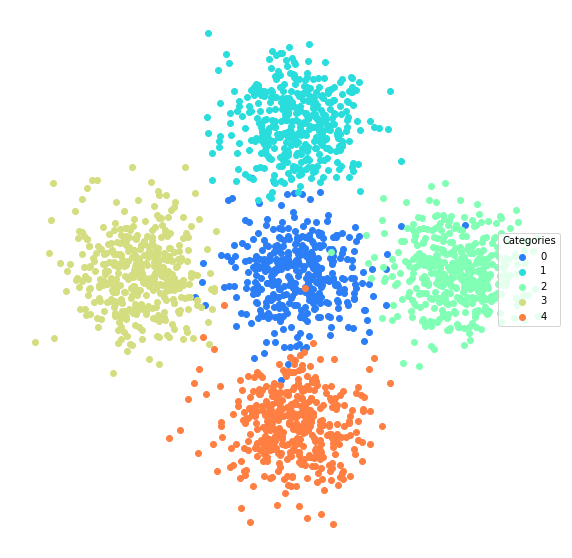

In [94]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [95]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

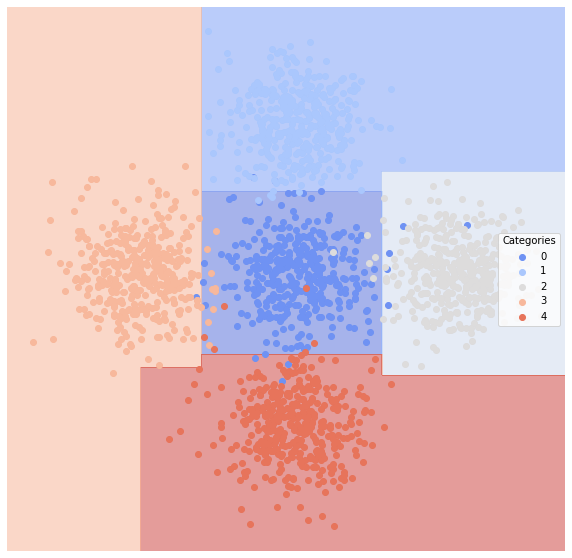

In [96]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [97]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.979084,0.919643,0.906126,0.980952
1,0.010,0.979687,0.990196,0.960474,0.961905
2,0.008,0.982470,0.988889,0.962643,0.967391
3,0.010,0.981414,0.978261,0.952704,0.967742
4,0.002,0.995238,1.000000,0.992476,0.990476


Lets look at accuracy:

In [98]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.974

What happens if we trim the tree?

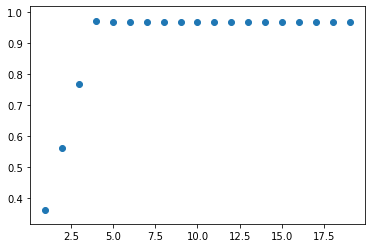

In [99]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [100]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [101]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

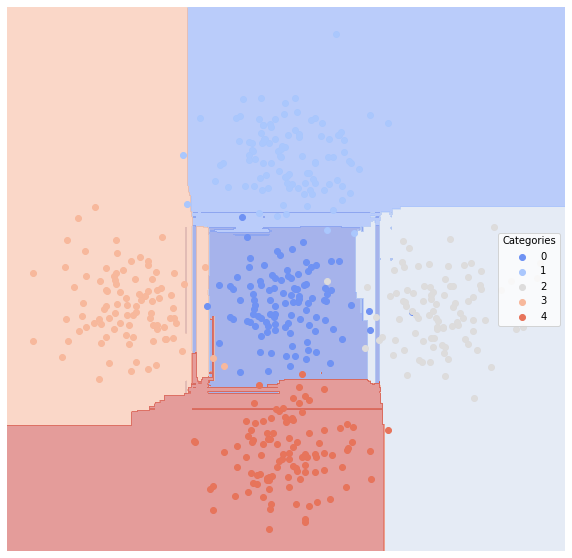

In [102]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [103]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.964798,0.917431,0.883744,0.952381
1,0.010,0.979687,0.990196,0.960474,0.961905
2,0.016,0.973359,0.956522,0.922934,0.956522
3,0.010,0.985562,0.968085,0.951266,0.978495
4,0.008,0.984448,0.990291,0.967997,0.971429


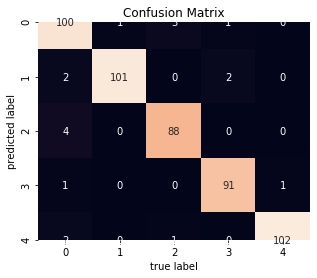

In [104]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [783]:
#I'm now using the decision tree for my own data
#I'm changing the names of the variables to fir my data
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


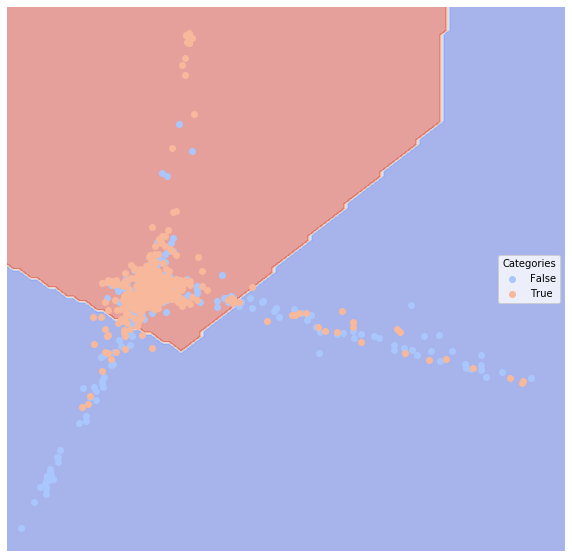

In [784]:
lucem_illud_2020.plotregions(clf_tree, train_data_df)

In [785]:
lucem_illud_2020.evaluateClassifier(clf_tree, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.238304,0.708408,1.000000,0.655120,0.416816
True,0.238304,0.708408,0.712775,0.712775,1.000000


In [786]:
sklearn.metrics.accuracy_score(train_data_df['category'],clf_tree.predict(np.stack(train_data_df['vect'], axis = 0)))

0.7616959064327485

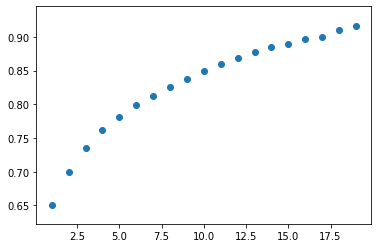

In [787]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(train_data_df['category'], tree2.predict(np.stack(train_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [788]:

tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [789]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

In [ ]:
lucem_illud_2020.plotregions(bag, train_data_df)

In [ ]:
lucem_illud_2020.evaluateClassifier(bag, train_data_df)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(bag, train_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [793]:
#I'm changin the variable names so they fit my dataset, as well as the name of the dataset to ObamaClintonReleases
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [794]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [796]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_data_df['text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [798]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [799]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.190789,0.795804,0.795678,0.688164,0.720641
True,0.190789,0.795804,0.817229,0.787804,0.870968


In [802]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['nb_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.7653958944281525


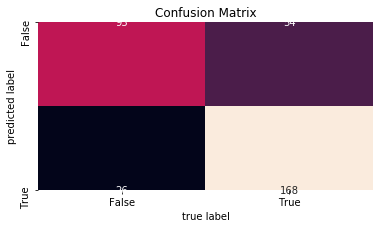

In [808]:
#confision matrix
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_data_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


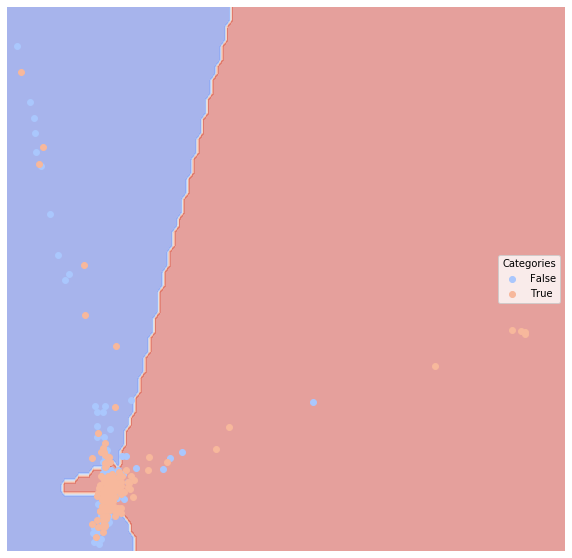

In [806]:
lucem_illud_2020.plotregions(clf_knearest, test_data_df)

In [829]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.7567567567567568

In [827]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.865979381443299

In [830]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8076923076923077

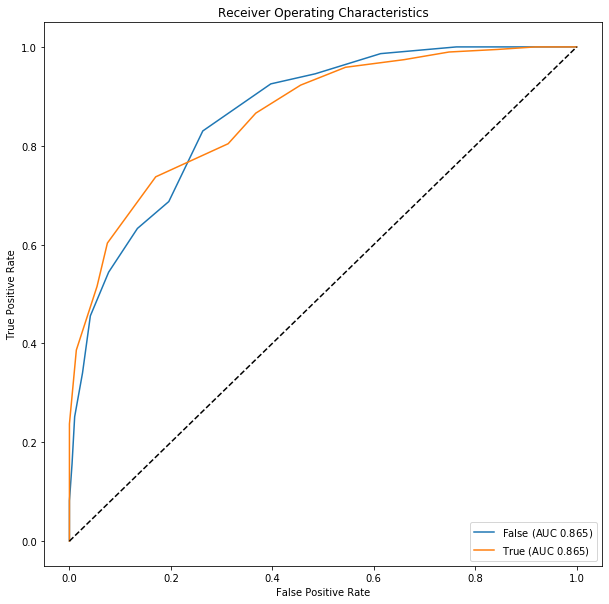

In [832]:
lucem_illud_2020.plotMultiROC(clf_knearest, test_data_df)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [ ]:
data = pandas.read_csv()

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

In [ ]:
#Neural Nets

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

In [ ]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

In [ ]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

In [ ]:
lucem_illud_2020.plotMultiROC(clf_svm, test_redditDf)